### Compare Imputation scores

This is an investigation to determine which method is best for filling in the fairly large number of missing Age values.
I will compare:

- Filling in the mean value of all ages
- Filling in the median value grouped by Sex, Title and pclass
- Imputation using MICE (Multivariate/Multiple Imputation by Chained Equations)

First get the data (which has already some cleaning applied) and import the correct libraries:

In [19]:
# Import libraries

import numpy as np
from numpy.random import random_integers
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

%matplotlib inline

print('Libraries Ready!')

Libraries Ready!


In [20]:
# Load the full training and test dataset, saved to csv on day 61
full = pd.read_csv('/home/sophie/Python/notechain/Titanic/data/061_full.csv', header=0) 

print(full.count())

Age             1046
Parch           1309
Pclass          1309
SibSp           1309
FamSize         1309
Sex_female      1309
Sex_male        1309
Embarked_C      1309
Embarked_Q      1309
Embarked_S      1309
Title_Master    1309
Title_Miss      1309
Title_Mr        1309
Title_Mrs       1309
Title_Rare      1309
dtype: int64


### Impute Age from Mean Age

In [21]:
# rename the dataframe
full_mean = full.copy()


full_mean['Age'].fillna(full_mean['Age'].mean(), inplace = True)

print(full_mean['Age'][0:10])

0    22.000000
1    38.000000
2    26.000000
3    35.000000
4    35.000000
5    29.881138
6    54.000000
7     2.000000
8    27.000000
9    14.000000
Name: Age, dtype: float64


### Impute Age based on Sex, Title and Pclass

Best to import the data again with the columns in categories


In [22]:
# Load the full training and test dataset, saved to csv on day58
df = pd.read_csv('/home/sophie/Python/notechain/Titanic/data/058_full.csv', header=0)


This is code copied straight from [052-Titanic](052-Titanic_new.ipynb):

In [23]:
# Make an array where null values are False.
mask_Age = df.Age.notnull()

# New dataframe where all rows have a value for age. 
Age_Sex_Title_Pclass = df.loc[mask_Age, ["Age", "Title", "Sex", "Pclass"]]

# Groupby object to group by Title, Pclass and Sex
Filler_Ages_1 = Age_Sex_Title_Pclass.groupby(by = ["Title", "Pclass", "Sex"]).median()

# This moves both Sex and Pclass into column headers and does so in that order. 
Filler_Ages = Filler_Ages_1.Age.unstack(level = -1).unstack(level = -1)

mask_Age = df.Age.isnull()  # A mask where null values are True

# New DataFrame with missing values for age
Age_Sex_Title_Pclass_missing = df.loc[mask_Age, ["Title", "Sex", "Pclass"]]

In [24]:
# Look-up function for the calculated median ages. 
def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age
    
# Make a new column on "missing" dataframe and add the median value to each row. 
Age_Sex_Title_Pclass_missing["Age"] = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis= 1)

# reform the 'Age' column.
df["AgeFill"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])

In [25]:
# use the factorized "full" dataset and add our new age column to it

full3cols = pd.concat([full,df['AgeFill']], axis=1) 

print(list(full3cols))

['Age', 'Parch', 'Pclass', 'SibSp', 'FamSize', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'AgeFill']


In [26]:
# Drop the old 'Age' column

full3cols = full3cols.drop(['Age'], axis=1)

print(list(full3cols))

['Parch', 'Pclass', 'SibSp', 'FamSize', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'AgeFill']


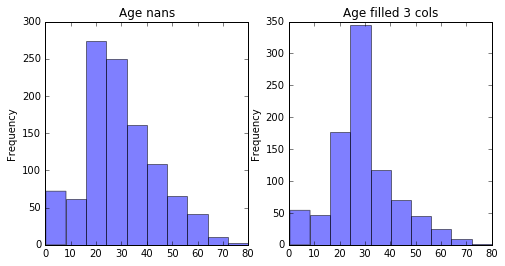

In [37]:
# quick peak at the age distribution using the 3 cols
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

df['Age'].plot.hist(alpha=0.5, ax=axes[0], title = 'Age nans')
full3cols['Age'].plot.hist(alpha=0.5, ax=axes[1], title = 'Age filled 3 cols')

In [38]:
# save full3cols to be compared to others
path = '/home/sophie/Python/notechain/Titanic/data'

full3cols.to_csv('%s/064_full3cols.csv'%path, index=False)

### Impute Age using MICE

We need to get the dataframe into numerical values. This means using dummies to transform categorical variables into 1s and 0s. There are two options to using MICE:

- update the `complete` method with code to handle a pandas dataframe
- convert the dataframe to a matrix and use MICE as is and then convert back.

I will use the former here.

In [27]:
from fancyimpute import MICE

# change MICE to MyMice to work with a dataFrame
class MyMice(MICE):    
    def complete(self, X):
        if self.verbose:
            print("[MICE] Completing matrix with shape %s" % (X.shape,))
        X_completed = X.copy()
        imputed_arrays, missing_mask = self.multiple_imputations(X)
        # average the imputed values for each feature
        average_imputated_values = imputed_arrays.mean(axis=0)
        
        ### New Code###
                
        ### Loop over each column, check for nans and if it is, we can mask the nans and insert the new values.
        for col in list(X_completed):
        
            #Look for a nan in this column
            nancount = len(X_completed[col][X_completed[col].isnull()])
        
            # If we have pass the correctly formatted array, there should only be one nancount > 0. 
            if nancount > 0:
                        
                #create a nan mask on the column then fill in the values.
                X_completed[col][X_completed[col].isnull()] = average_imputated_values
                       
                return X_completed

In [28]:
solver = MyMice(verbose=False)

#apply MICE
full_MICE = solver.complete(full)

### Compare the 3 arrays using randomforest classifier and cross validation

- full_mean
- full3cols
- full_MICE

Using [this](http://scikit-learn.org/stable/auto_examples/missing_values.html) as a guide.

In [29]:
# First need to import the training data so we have the "survived column"
train = pd.read_csv('/home/sophie/projects/Titanic/data/clean_train.csv', header=0).astype(np.float32)

print(train[-1:])

     Survived  Pclass  SibSp  Parch  Fare  Embarked  Gender  AgeFill
888       0.0     3.0    0.0    0.0  7.75       2.0     1.0     32.0


In [31]:
# Chop off the training data from the three filled in datasets
full_mean = full_mean[0:889]
full3cols = full_mean[0:889]
full_MICE = full_mean[0:889]

print(len(full_mean))

889


In [32]:
# estimate the score on the simple imputation with mean values, with no missing values
estimator = RandomForestClassifier(n_estimators=100)
score_mean = cross_val_score(estimator, full_mean, train['Survived'], cv=10)
print(score_mean)

[ 0.47191011  0.51685393  0.50561798  0.46067416  0.57303371  0.60674157
  0.58426966  0.43820225  0.58426966  0.52272727]


In [33]:
# estimate the score on the simple imputation with mean values, with no missing values
estimator = RandomForestClassifier(n_estimators=100)
score_3cols = cross_val_score(estimator, full3cols, train['Survived'], cv=10)

#score_3cols_2 = cross_val_score(estimator, full3cols, train['Survived'], cv=5)
#print(score_3cols_2)

In [34]:
# estimate the score on the simple imputation with mean values, with no missing values
estimator = RandomForestClassifier(n_estimators=100)
score_MICE = cross_val_score(estimator, full_MICE, train['Survived'], cv=10)

In [35]:
print("Score using age mean imputed values =  %f +/- %f " % (score_mean.mean(),score_mean.std()))
print("Score using age imputed from median of Title, Plcass and Sex =  %f +/- %f " % (score_3cols.mean(), score_3cols.std()))
print("Score using age MICE imputed values =  %f +/- %f " % (score_MICE.mean(),score_MICE.std()))

Score using age mean imputed values =  0.526430 +/- 0.055616 
Score using age imputed from median of Title, Plcass and Sex =  0.528690 +/- 0.055074 
Score using age MICE imputed values =  0.529775 +/- 0.051493 
